In [1]:
import astropy.constants as const
import astropy.units as u
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy.integrate
from tqdm import tqdm

from plotting import label_axes

In [2]:
# constants
mpic2 = 134.9768 * u.MeV
mpc2 = (const.m_p * const.c**2).to(u.GeV)

In [3]:
n_H = 4 / (u.cm**3)
K_pi = 0.17  # mean multiplicity for delta-approximation, we will assume that E_pi = K_pi * E_p

In [4]:
alpha = 2.4

def spectral_density(
    E: u.Quantity[u.eV], n_0: u.Quantity[1 / u.eV]
) -> u.Quantity[1 / u.eV]:
    return n_0 * ((E / u.TeV).to(u.dimensionless_unscaled)).value ** (-alpha)

# Problem statement

Given a source with identical-spectrum populations of $e^-$ and $p$, compute $W_e / W_p$ under condition of $Q_e = Q_p$ at $E = 1~\text{TeV}$


## Proton-induced $\gamma$-ray spectrum


### $p + p \to \pi_0$ cross-section

Total cross-section is given in 
```
Norbury, J. W. (2009). Total cross section parameterizations for pion production in nucleon–nucleon collisions. In Nuclear Instruments and Methods in Physics Research Section B: Beam Interactions with Materials and Atoms (Vol. 267, Issue 7, pp. 1209–1212). Elsevier BV. https://doi.org/10.1016/j.nimb.2009.02.067
```


high energy sigma_pp limit = 142.8571005647761 mbarn


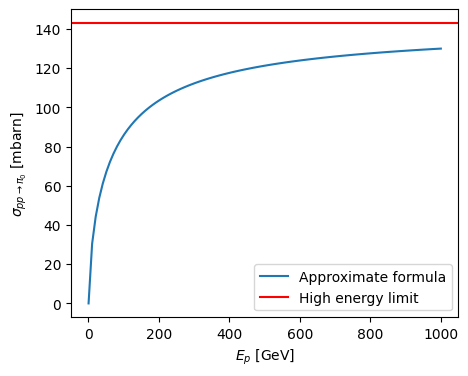

In [5]:
def sigma_pp_pi0(E_p: u.Quantity[u.eV]) -> u.Quantity[u.mbarn]:
    T_lab = (E_p - mpc2).to(u.GeV).value

    HIGH_E_THRESHOLD = 1e9  # GeV
    overflow_mask = T_lab > HIGH_E_THRESHOLD
    T_lab[overflow_mask] = HIGH_E_THRESHOLD

    positive_mask = T_lab > 0
    T_lab_pos = T_lab[positive_mask]
    res = np.zeros_like(T_lab) * u.mbarn
    res[positive_mask] = (
        (0.007 + 0.1 * np.log(T_lab_pos) / T_lab_pos + 0.3 / (T_lab_pos**2)) ** (-1)
    ) * u.mbarn
    return res


sigma_pp_pi0_high_energy = sigma_pp_pi0(np.array([1000]) * u.PeV)[0]
print(f"high energy sigma_pp limit = {sigma_pp_pi0_high_energy}")

_, ax = plt.subplots(figsize=(5, 4))

E_grid = np.linspace(mpc2 * 1.01, 1000 * u.GeV, 100)
ax.plot(E_grid, sigma_pp_pi0(E_grid), label="Approximate formula")
ax.axhline(sigma_pp_pi0_high_energy, color="r", label="High energy limit")
label_axes(ax, "E_{p}", "\\sigma_{pp \\to \\pi_0}")
ax.legend()
plt.show()

Differential cross-section is given by total cross section and a phenomenological shape function

/Users/njvh/Documents/Science/GSSI/HEAPTH/exam/venv/lib/python3.12/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


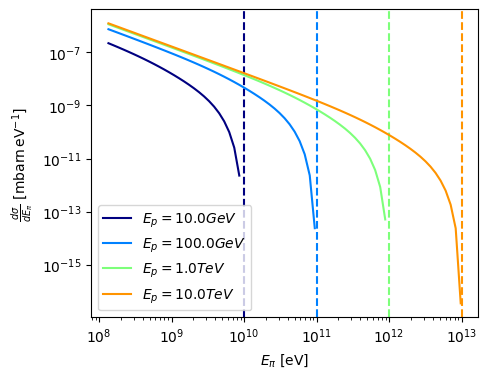

In [6]:
def diff_cross_section_f(x: np.ndarray | float) -> np.ndarray:
    return 0.67 * (1 - x) ** 3.5 + 0.5 * np.exp(-18 * x)


def dsigma_dEpi(
    E_p: u.Quantity[u.eV], E_pi: u.Quantity[u.eV]
) -> u.Quantity[u.mbarn / u.eV]:
    total = sigma_pp_pi0(u.Quantity([E_p]))
    shape = diff_cross_section_f(E_pi / E_p)
    return (total * shape / E_pi).to(u.mbarn / u.eV)


_, ax = plt.subplots(figsize=(5, 4))
E_p_grid = [10 * u.GeV, 100 * u.GeV, 1 * u.TeV, 10 * u.TeV]
E_pi_grid = np.logspace(np.log10(mpic2.to(u.eV).value), 15, 100) * u.eV
cmap = matplotlib.colormaps["jet"]
for idx, E_p in enumerate(E_p_grid):
    color = cmap(idx / len(E_p_grid))
    ax.loglog(E_pi_grid, dsigma_dEpi(E_p=E_p, E_pi=E_pi_grid), label=f"$ E_{{p}} = {E_p} $", color=color)
    ax.axvline(E_p, linestyle="--", color=color)
ax.legend()
label_axes(ax, "E_{\\pi}", "\\frac{d \\sigma}{dE_\\pi}")
plt.show()

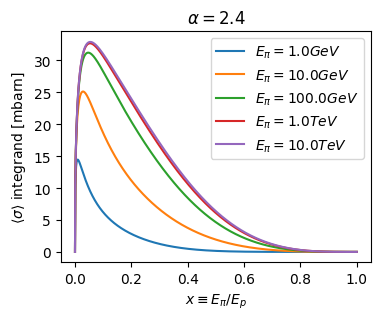

In [7]:
def sigma_average_integrand(
    x_grid: np.ndarray | float,
    E_pi: u.Quantity[u.eV],
) -> u.Quantity[u.mbarn]:

    def _internal(x_grid):
        return (
            diff_cross_section_f(x_grid)
            * x_grid ** (alpha - 2)
            * sigma_pp_pi0(E_pi / x_grid)
        )

    if E_pi.size != 1:
        raise ValueError("E_pi must be scalar")
    if isinstance(x_grid, float):
        return _internal(x_grid) if 0 < x_grid < 1 else 0
    else:
        result = np.zeros_like(x_grid) * u.mbarn
        mask = np.logical_and(x_grid > 0, x_grid < 1)
        result[mask] = _internal(x_grid[mask])
        return result


_, ax = plt.subplots(figsize=(4, 3))
x_grid = np.linspace(0, 1, 1000)
E_pi_grid = [1 * u.GeV, 10 * u.GeV, 100 * u.GeV, 1 * u.TeV, 10 * u.TeV]
for E_pi in E_pi_grid:
    ax.plot(x_grid, sigma_average_integrand(x_grid, E_pi), label=f"$E_\\pi = {E_pi}$")
label_axes(ax, "x \\equiv E_\\pi / E_p", "\\langle \\sigma \\rangle~\\text{integrand}")
ax.set_title(f"$\\alpha = {alpha}$")
ax.legend()
plt.show()

Y_alpha = 0.07603554023318222


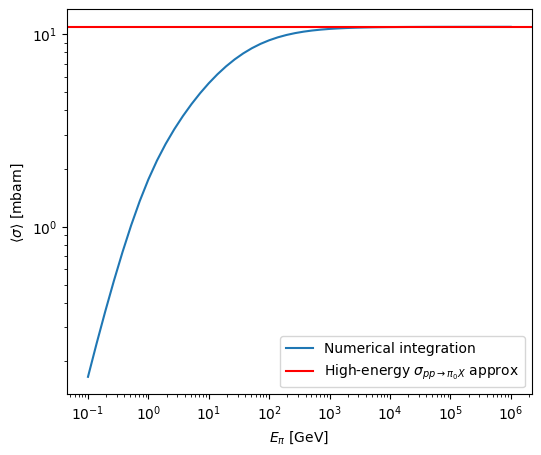

In [8]:
def sigma_average(E_pi: u.Quantity[u.eV]) -> u.Quantity[u.mbarn]:
    res: list[float] = []
    for E_pi_ in E_pi:
        value, _ = scipy.integrate.quad(
            lambda x: sigma_average_integrand(x, E_pi=u.Quantity([E_pi_])).to(u.mbarn).value,
            a=0,
            b=1,
        )
        res.append(value)
    return np.array(res) * u.mbarn


_, ax = plt.subplots(figsize=(6, 5))

E_pi_grid = np.logspace(-1, 6, 50) * u.GeV
ax.loglog(E_pi_grid, sigma_average(E_pi_grid), label="Numerical integration")

Y_alpha, _ = scipy.integrate.quad(
    lambda x: diff_cross_section_f(x) * x ** (alpha - 2), a=0, b=1
)
print(f"{Y_alpha = }")
ax.axhline(
    Y_alpha * sigma_pp_pi0_high_energy,
    color="r",
    label=f"High-energy $ \\sigma_{{pp \\to \\pi_0 X}} $ approx",
)

label_axes(ax, "E_\\pi", "\\langle \\sigma \\rangle")
ax.legend()
plt.show()

### Pion emissivity

Three approximations:
- $\delta$-approximation
- Carmelo's formula (p. 26 of lectures), assuming high-energy $\sigma$ limit
- full numerical integration of $\langle \sigma \rangle(\alpha, E_\pi)$

In [9]:
from typing import Literal

EMISSIVITY = 1 / (u.eV * u.yr)


def q_pi(
    E_pi_grid: u.Quantity[u.eV],
    n_0: u.Quantity[1 / u.eV],
    method: Literal["delta", "high-e-sigma", "exact"],
) -> u.Quantity[EMISSIVITY]:
    norm = const.c * n_H
    if method == "delta":
        exact_E_p_grid = mpc2 + (E_pi_grid - mpic2) / K_pi
        return (
            (norm / K_pi)
            * sigma_pp_pi0(exact_E_p_grid)
            * spectral_density(E=exact_E_p_grid, n_0=n_0)
        ).to(EMISSIVITY)
    elif method == "exact":
        return norm * spectral_density(E=E_pi_grid, n_0=n_0) * sigma_average(E_pi_grid)
    elif method == "high-e-sigma":
        return (
            norm
            * spectral_density(E=E_pi_grid, n_0=n_0)
            * Y_alpha
            * sigma_pp_pi0_high_energy
        )
    else:
        raise ValueError(f"Unexpected method: {method!r}")

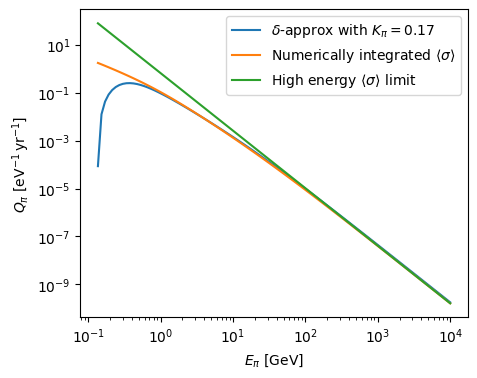

In [10]:
n_0p_example = 1 / u.eV
E_pi_grid = np.logspace(np.log10(1.01 * mpic2.to(u.eV).value), 13, 100) * u.eV

_, ax = plt.subplots(figsize=(5, 4))

exact_E_p_grid = mpc2 + (E_pi_grid - mpic2) / K_pi
ax.loglog(
    E_pi_grid.to(u.GeV),
    q_pi(E_pi_grid, n_0=n_0p_example, method="delta"),
    label=f"$ \\delta $-approx with $ K_\\pi = {K_pi} $",
)

ax.plot(
    E_pi_grid,
    q_pi(E_pi_grid, n_0=n_0p_example, method="exact"),
    label="Numerically integrated $\\langle \\sigma \\rangle$",
)

ax.plot(
    E_pi_grid,
    q_pi(E_pi_grid, n_0=n_0p_example, method="high-e-sigma"),
    label="High energy $\\langle \\sigma \\rangle$ limit",
)

ax.legend()
label_axes(ax, "E_\\pi", "Q_\\pi")

### Proton-induced $\gamma$-ray emissivity

In [11]:
def q_gamma(
    E_gamma_grid: u.Quantity[u.eV],
    n_0: u.Quantity[1 / u.eV],
    method: Literal["high-energy", "exact"],
) -> u.Quantity[EMISSIVITY]:
    if method == "high-energy":
        return (
            (2 / alpha)
            * const.c
            * n_H
            * sigma_pp_pi0_high_energy
            * Y_alpha
            * spectral_density(E_gamma_grid, n_0=n_0)
        ).to(EMISSIVITY)
    elif method == "exact":
        res: list[float] = []

        def integrand(log_E_pi_eV: float) -> float:
            E_pi = np.exp(log_E_pi_eV) * u.eV
            if np.isinf(E_pi):
                return 0
            numerator = q_pi(
                E_pi_grid=u.Quantity([E_pi]),
                n_0=n_0,
                method="exact",
            )
            denominator = np.sqrt(E_pi**2 - mpic2**2)
            #         VVVV Jacobian or x -> log x transform
            result = (E_pi * numerator / denominator).to(1 / (u.yr * u.eV))
            return result.value

        for E_gamma in tqdm(E_gamma_grid):
            lower_limit = (E_gamma + (mpic2**2) / (4 * E_gamma)).to(u.eV)
            # upper_limit = 1000 * u.TeV
            integrated, _ = scipy.integrate.quad(
                integrand,
                a=np.log(lower_limit.value),
                b=np.inf,
                # b=np.log(upper_limit.value),
            )
            res.append(2 * integrated)
        return np.array(res) * EMISSIVITY

  0%|          | 0/60 [00:00<?, ?it/s]/Users/njvh/Documents/Science/GSSI/HEAPTH/exam/venv/lib/python3.12/site-packages/astropy/units/quantity.py:671: RuntimeWarning: overflow encountered in square
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/pt/5p7r1p1j49n8f_88l1j7jtwc0000gn/T/ipykernel_10787/610363386.py:19: RuntimeWarning: overflow encountered in exp
  E_pi = np.exp(log_E_pi_eV) * u.eV
100%|██████████| 60/60 [01:15<00:00,  1.27s/it]


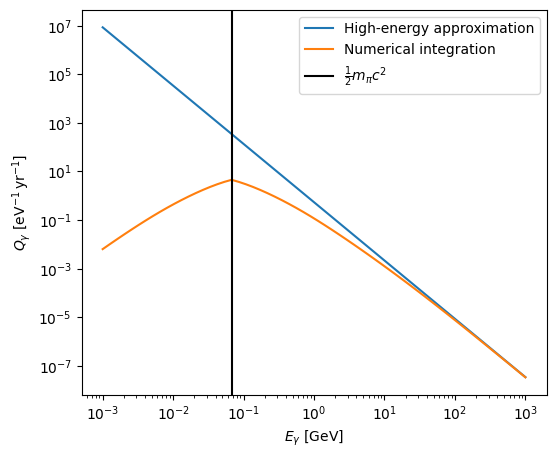

In [12]:
E_gamma_grid = np.logspace(-3, 3, 60) * u.GeV

_, ax = plt.subplots(figsize=(6, 5))

for method, label in (
    ("high-energy", "High-energy approximation"),
    ("exact", "Numerical integration"),
):
    q_gamma_arr = q_gamma(E_gamma_grid, n_0=n_0p_example, method=method)
    ax.loglog(
        E_gamma_grid.to(u.GeV),
        q_gamma_arr,
        label=label,
    )

ax.axvline(mpic2 / 2, color="black", label="$ \\frac{1}{2} m_\\pi c^2 $")

ax.legend()
label_axes(ax, "E_\\gamma", "Q_\\gamma")
plt.show()